# **Feline vs. Canine: The Ultimate Showdown of Image Classification**



>



In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np

from PIL import Image
from PIL import ImageOps

import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# libraries for data plotting
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# library for evaluation
from sklearn import metrics

# libraries for ML algorithms
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from random import randint
from random import seed
from sklearn.preprocessing import LabelEncoder
RANDOM_SEED = 100

##Let the games begin!
### Folder Unzipping

In [ ]:
#An easier way to unzips the libraries
#This downloads the zip file directly

!pip install --q --upgrade --no-cache-dir gdown
!gdown 1ea-X2EK6a49Ond-YJZ6Dt0nqCQFpW0Pi

Downloading...
From: https://drive.google.com/uc?id=1ea-X2EK6a49Ond-YJZ6Dt0nqCQFpW0Pi
To: /content/data.zip
100% 472M/472M [00:06<00:00, 67.5MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

##How about the game server?
###Loading the data sets

In [ ]:
#load training data
df_train = pd.read_csv('train.csv')

#Load the test data
df_test = pd.read_csv('test.csv')


# summarise the details
print(f'Number of train entries: {len(df_train)}')
print(f'Number of test entries: {len(df_test)}')


Number of train entries: 10000
Number of test entries: 1000


##Are the cats and dogs in uniform?
### Encoding the training data

In [ ]:
#Create an encoder model
le = LabelEncoder()

#Fit the model on train data
le.fit(df_train['label'])

#Transform the label column and add the transformed column as 'encoded-data'
df_train['encoded_data'] = le.transform(df_train['label'])

In [ ]:
#Check the data
df_train.head()

,id,label,encoded_data
0,1,cat,0
1,2,dog,1
2,3,cat,0
3,4,cat,0
4,5,cat,0


## Can Plotly tell us how many cats and dogs?

In [ ]:
counts = df_train['label'].value_counts()
counts = counts.reset_index()
counts.columns = ['animal', 'count']

fig = px.scatter(counts, x="animal", y="count",
                 size="count", size_max=150, color="count",
                 hover_name="count", text="animal",
                 title="Animals countplot")

# Set the x-axis and y-axis labels
fig.update_layout(xaxis_title="Animal type", yaxis_title="count", height=600, width=1000, template="plotly_dark")


# Show the chart
fig.show()

## Loading the digital cats and Dogs
###Loading the test and train images

In [ ]:
#Create a function that loads the images and resizes if necessary, and returns the images
def load_images(ids, folder_path, dim):
  images = []
  for id in ids:
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

# Resize function
    if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
      img = cv2.resize(img, dim)
    images.append(img)
  return images

## Ensuring they follow the rules :)-
###Resizing the images if necessary

In [ ]:
#Specify the base dimensions
base_dim = (200, 200)

# load train images
train_image_folder = os.path.join('train_images')
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join('test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

Number of training images loaded: 10000
Number of testing images loaded: 1000


## The Scoreboard :)-
### Function for Evaluation

In [ ]:
# method to plot confusion matrix
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['0', '1']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

# method to calculate evaluation results
def evaluate(actuals, predictions):
  accuracy = metrics.accuracy_score(actuals, predictions)
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=[0, 1])
  return accuracy, confusion_matrix

## The Referees )-:
###Model building

In [ ]:
#Define SVM --linear
def build_svm_lin_model(X_train, X_val, y_train, y_val):
  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)
  return clf

In [ ]:
#Define SVM --rbf
def build_svm_rbf_model(X_train, X_val, y_train, y_val):
  clf = svm.SVC(kernel='rbf', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)
  return clf

In [ ]:
#Define SVM --poly
def build_svm_poly_model(X_train, X_val, y_train, y_val):
  clf = svm.SVC(kernel='poly', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)
  return clf

In [ ]:
#Define SVM --sigmoid
def build_svm_sigm_model(X_train, X_val, y_train, y_val):
  clf = svm.SVC(kernel='sigmoid', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)
  return clf

In [ ]:
#Define random forest
def build_rfc_model(X_train, X_val, y_train, y_val):
  clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)
  return clf

## Judge 1
### Feature Extraction: grayscaling only

In [ ]:
#Create a function for grayscaling, vectorizing, and feature extraction

def get_features_m1(images):
  features_list = []
  for img in images:
    #Grayscaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Vectorization
    features = img_grayscaled.flatten()

    #Appending the new features to a list
    features_list.append(features)

  #Converting the list to an array
  features_list = np.array(features_list)

  #Return the list
  return features_list

In [ ]:
# Run the get_features function on the train images and print the shape
features_train = get_features_m1(train_images)
print(features_train.shape)

(10000, 22500)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# **Let the games Begin!**
### Model Training

#### Model 1

- gray scaling<br>
- image vector<br>
- SVM Linear <br>

In [ ]:
# train model
m1 = build_svm_lin_model(X_train, X_val, y_train, y_val)

Accuracy: 0.516


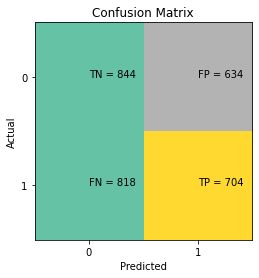

In [ ]:
# make predictions on validation data
y_pred = m1.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)


#### Model 2

- gray scaling<br>
- image vector<br>
- SVM rbf <br>

In [ ]:
# train model
m2 = build_svm_rbf_model(X_train, X_val, y_train, y_val)

Accuracy: 0.6423333333333333


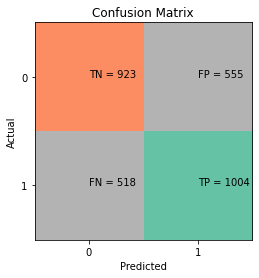

In [ ]:
# make predictions on validation data
y_pred = m2.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

#### Model 3

- gray scaling<br>
- image vector<br>
- SVM poly <br>

In [ ]:
# train model
m3 = build_svm_poly_model(X_train, X_val, y_train, y_val)

Accuracy: 0.5986666666666667


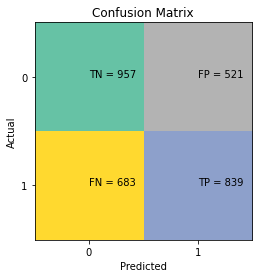

In [ ]:
# make predictions on validation data
y_pred = m3.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

#### Model 4

- gray scaling<br>
- image vector<br>
- SVM sigm <br>

In [ ]:
# train model
m4 = build_svm_sigm_model(X_train, X_val, y_train, y_val)

Accuracy: 0.527


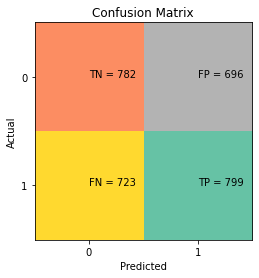

In [ ]:
# make predictions on validation data
y_pred = m4.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

## Feature Extraction with Gaussian smoothing

In [ ]:
#Function for grayscaling, blurring, and vectorizing
def get_features_m2(images):
  features_list = []
  for img in images:
    #Grayscaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Blurring the image
    img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)


    # vectorise/ feature extraction
    features = img_blurred.flatten()

    #Append the features to a list
    features_list.append(features)

  #Convert feature list to np array
  features_list = np.array(features_list)

  #Return the array
  return features_list

#### Model 5

- gray scaling, smoothing: Gaussian <br>
- image vector<br>
- SVM --rbf <br>


In [ ]:
# feature extraction
features_train = get_features_m2(train_images)
print(features_train.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# train model


In [ ]:
m5 = build_svm_rbf_model(X_train, X_val, y_train, y_val)

Accuracy: 0.64


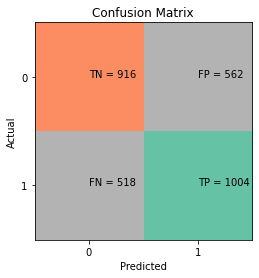

In [ ]:
# make predictions on validation data
y_pred = m5.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

## Feature Extraction using Edge map to Vector

In [ ]:
# method to get image features
def get_features_m3(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

#### Model 6

- gray scaling <br>
- edge map to vector<br>
- SVM - **rbf** <br>


In [ ]:
# feature extraction
features_train = get_features_m3(train_images)
print(features_train.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m6 = build_svm_rbf_model(X_train, X_val, y_train, y_val)

Accuracy: 0.6083333333333333


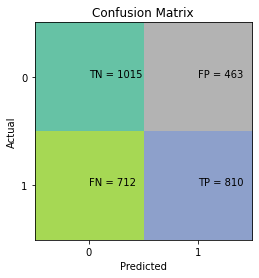

In [ ]:
# make predictions on validation data
y_pred = m6.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

##Feature Extraction with HOG vectorization

In [ ]:
# method to get image features
def get_features_m4(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

#### Model 7
- gray scaling <br>
- HOG features<br>
- SVM rbf<br>

In [ ]:
# feature extraction
features_train = get_features_m4(train_images)
print(features_train.shape)

(10000, 3780)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m7 = build_svm_rbf_model(X_train, X_val, y_train, y_val)

Accuracy: 0.7346666666666667


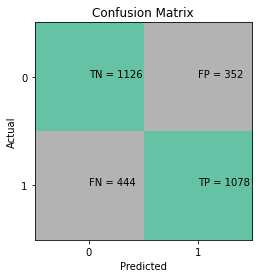

In [ ]:
# make predictions on validation data
y_pred = m7.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

## Feature extraction with image vector and edge map to vector

In [ ]:
# method to get image features
def get_features_m5(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

#### Model 8


- gray scaling <br>
- image vector + edge map vector<br>
- SVM --rbf<br>

In [ ]:
# feature extraction
features_train = get_features_m5(train_images)
print(features_train.shape)

(10000, 80000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m8 = build_svm_rbf_model(X_train, X_val, y_train, y_val)

Accuracy: 0.5786666666666667


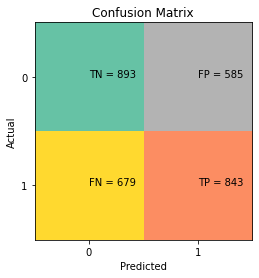

In [ ]:
# make predictions on validation data
y_pred = m8.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

## Feature Extraction with Bilateral Filtering

In [ ]:
#Function for grayscaling, blurring, and vectorizing
def get_features_m6(images):
  features_list = []
  for img in images:
    #Grayscaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Blurring the image
    img_blurred = cv2.bilateralFilter(img_grayscaled, 7, 60, 60)

       # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

#### Model 9
- Grayscaling, Bilateral Filtering <br>
- HOG features<br>
- SVM rbf<br>

In [ ]:
# feature extraction
features_train = get_features_m6(train_images)
print(features_train.shape)

(10000, 3780)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m9 = build_svm_rbf_model(X_train, X_val, y_train, y_val)

Accuracy: 0.7346666666666667


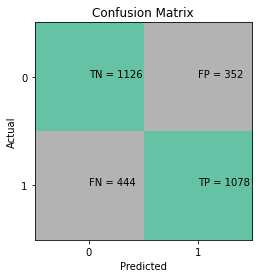

In [ ]:
# make predictions on validation data
y_pred = m9.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

#### Model 10
- grayscalying, bilateral filtering <br>
- HOG features<br>
- Random forest<br>

In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m10 = build_rfc_model(X_train, X_val, y_train, y_val)

Accuracy: 0.701


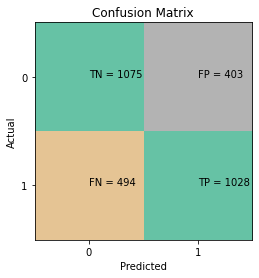

In [ ]:
# make predictions on validation data
y_pred = m10.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

#### Model 11
- grayscalying, bilateral filtering <br>
- HOG features<br>
- PCA <br>
- SVM - rbf<br>

In [ ]:
# feature extraction
features_train = get_features_m6(train_images)
print(features_train.shape)

(10000, 3780)


In [ ]:
# PCA
from sklearn.decomposition import PCA

# create PCA object
pca = PCA(n_components=min(features_train.shape[0], features_train.shape[1]-1))

# fit PCA to features
pca.fit(features_train)

# transform features using PCA
features_train_pca = pca.transform(features_train)



In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m11 = build_svm_rbf_model(X_train, X_val, y_train, y_val)

Accuracy: 0.736


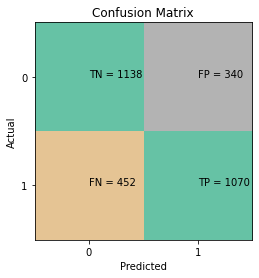

In [ ]:
# make predictions on validation data
y_pred = m11.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

#### Model 12
- grayscalying, bilateral filtering <br>
- HOG features<br>
- PCA <br>
- SVM - rbf<br>

In [ ]:
# PCA
from sklearn.decomposition import PCA

# create PCA object
pca = PCA(n_components=100)

# fit PCA to features
pca.fit(features_train)

# transform features using PCA
features_train_pca = pca.transform(features_train)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m12 = build_svm_rbf_model(X_train, X_val, y_train, y_val)

Accuracy: 0.7503333333333333


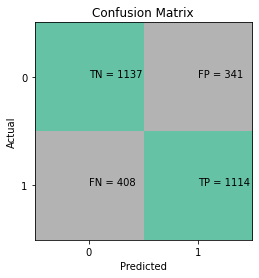

In [ ]:
# make predictions on validation data
y_pred = m12.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

##Feature Extraction using Morphology, GaussianBlur, adaptiveThreshold

In [ ]:
def get_features_m7(images):
  features_list = []
  for img in images:
    # convert image to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # apply Gaussian blur to reduce noise
    # apply Gaussian blur to reduce noise
    img_blurred = cv2.GaussianBlur(img_grayscaled, (3,3), 0)

    # apply adaptive thresholding to enhance contrast
    img_thresh = cv2.adaptiveThreshold(img_blurred, 280, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5)

    # apply morphology operations to remove small objects and fill gaps
    kernel = np.ones((3,3), np.uint8)
    img_morph = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel)
    img_morph = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel)


    # Resize image if necessary
    img_resized = cv2.resize(img_morph, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), block_norm='L2-Hys',transform_sqrt=True, feature_vector=True, visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train = get_features_m7(train_images)
print(features_train.shape)

(10000, 3780)


In [ ]:
# PCA
from sklearn.decomposition import PCA

# create PCA object
pca = PCA(n_components=107)

# fit PCA to features
pca.fit(features_train)

# transform features using PCA
features_train_pca = pca.transform(features_train)

In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca, df_train['encoded_data'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m13 = build_svm_rbf_model(X_train, X_val, y_train, y_val)

Accuracy: 0.7703333333333333


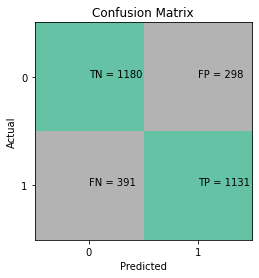

In [ ]:
# make predictions on validation data
y_pred = m13.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

#### Summary

|Model | Preprocessing | Vectorization Technique   |ML Model|PCA| Accuracy|
|------|---------------|------------|---------|--------|--------|
|M1  | gray scaling | Image Vector|SVM - Linear|No| 0.516 |
|M2    | gray scaling | Image Vector |SVM - rbf|No| 0.641 |
|M3    | gray scaling | Image Vector |SVM poly|No| 0.599 |
|M4    | gray scaling | Image Vector |SVM - Sigmoid|No| 0.527 |
|M5    | gray scaling, smoothing   | Image Vector |SVM - rbf|No| 0.64 |
|M6    | gray scaling| Edge map to Vector |SVM - rbf|No| 0.608 |
|M7    | gray scaling | HOG |SVM - rbf|No| 0.735 |
|M8    | gray scaling | Image Vector and Edge Map to Vector | SVM - linear |No|0.57866|
|M9    | gray scaling, Bilateral filtering | HOG |SVM - rbf|No| 0.735 |
|M10    | gray scaling | HOG |Random Forest|No| 0.701 |
|M11    | gray scaling | HOG |SVM - rbf|Yes| 0.736 |
|M12    | gray scaling | HOG |SVM - rbf|Yes(n_components = 107)| 0.752 |
|M13    | gray scaling, Gaussian smoothing, adaptive thresholding, Morphology | HOG |SVM - rbf|Yes(n_components = 107)| 0.771 |



## Make predictions on test images using model 13

In [ ]:
# feature extraction
features_test = get_features_m7(test_images)
print(features_test.shape)

pca.fit(features_test)
# transform features using PCA
features_test_pca = pca.transform(features_test)

# get model predictions
predictions = m13.predict(features_test_pca)
print(predictions)

(1000, 3780)
[1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0
 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0
 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0
 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1
 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1
 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1
 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1
 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0
 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1
 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 0 0 1 1 0

In [ ]:
#Add the predictions as a column in the test dataframe
df_test['prediction'] = predictions
df_test.head()

,id,prediction
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


## Decoding the predictions

In [ ]:
df_test['prediction'] = df_test['prediction'].map({0: 'cat', 1: 'dog'})

In [ ]:
df_test.head()

,id,prediction
0,1,dog
1,2,cat
2,3,cat
3,4,cat
4,5,cat


In [ ]:
#save to csv
df_test.to_csv('/content/test_prediction.csv', index=False)

In [ ]:
import json
test_file_path = "/content/test_prediction.csv"
df_test = pd.read_csv(test_file_path)
df_test = df_test[["id", "prediction"]]

data = []
for index, row in df_test.iterrows():
    data.append({'id': row['id'], 'prediction': row['prediction']})

print(data[0:5])

submission_file_path = "submission.json"
with open(submission_file_path, 'w') as fp:
    fp.write('\n'.join(json.dumps(i) for i in data))

[{'id': 1, 'prediction': 'dog'}, {'id': 2, 'prediction': 'cat'}, {'id': 3, 'prediction': 'cat'}, {'id': 4, 'prediction': 'cat'}, {'id': 5, 'prediction': 'cat'}]


# Muchas!!